# Imports

In [39]:
import numpy as np
#import pyaudio
import time
import matplotlib.pyplot as plt
%matplotlib inline

import essentia
# as there are 2 operating modes in essentia which have the same algorithms,
# these latter are dispatched into 2 submodules:

import essentia.standard
import essentia.streaming

# let's have a look at what is in there
#print dir(essentia.streaming)

# Essentia tutorial

## Standard processing

### Load data

In [2]:
# Essentia has a selection of audio loaders:
#
#  - AudioLoader: the basic one, returns the audio samples, sampling rate and number of channels
#  - MonoLoader: which returns audio, down-mixed and resampled to a given sampling rate
#  - EasyLoader: a MonoLoader which can optionally trim start/end slices and rescale according
#                to a ReplayGain value
#  - EqloudLoader: an EasyLoader that applies an equal-loudness filtering on the audio
#

# we start by instantiating the audio loader:
loader = essentia.standard.MonoLoader(filename = 'data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav')

# and then we actually perform the loading:
audio = loader()

# by default, the MonoLoader will output audio with 44100Hz samplerate


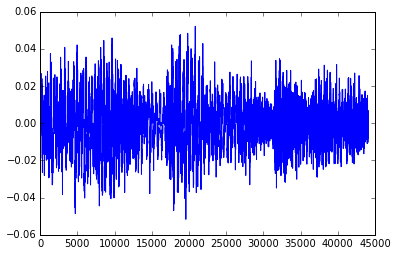

In [3]:
plt.plot(audio[1*44100:2*44100])
#show() # unnecessary if you started "ipython --pylab"

### Initialize functions

In [4]:
from essentia.standard import *

w = Windowing(type = 'hann')
# Applies windowing to audio signals. It optionally applies zero-phase windowing and optionally adds zero-padding.
# The resulting windowed frame size is equal to the incoming frame size plus the number of padded zeros. 
# The available windows are normalized (to have an area of 1) and then scaled by a factor of 2.
# Parms:
#  size (integer ∈ [2, ∞), default = 1024) : the window size
#  type (string ∈ {hamming, hann, triangular, square, blackmanharris62, blackmanharris70, blackmanharris74, 
#        blackmanharris92}, default = hann) : the window type, which can be 'hamming', 'hann', 'triangular',
#       'square' or 'blackmanharrisXX'
#  zeroPadding (integer ∈ [0, ∞), default = 0) : the size of the zero-padding
#  zeroPhase (bool ∈ {true, false}, default = true) a boolean value that enables zero-phase windowing

spectrum = Spectrum()
# Calculates the magnitude spectrum of an array of Reals. The resulting magnitude spectrum has a size 
# which is half the size of the input array plus one. Outputs spectrum (vector_real) - the magnitude spectrum
# of the input audio signal
# Parms: 
#  size (integer ∈ [1, ∞), default = 2048) : the expected size of the input audio signal 

mfcc = MFCC()
# Computes the mel-frequency cepstrum coefficients. As there is no standard implementation, the MFCC-FB40
# is used by default e.g.,: filterbank of 40 bands from 0 to 11000Hz, take the log value of the spectrum 
# energy in each mel band, DCT of the 40 bands down to 13 mel coefficients. 
# Outputs: 
#  bands (vector_real) - the energies in mel bands
#  mfcc (vector_real) - the mel frequency cepstrum coefficients
# Parms: 
#  highFrequencyBound (real ∈ (0, ∞), default = 11000) : the upper bound of the frequency range [Hz]
#  inputSize (integer ∈ (1, ∞), default = 1025) : the size of input spectrum
#  lowFrequencyBound (real ∈ [0, ∞), default = 0) : the lower bound of the frequency range [Hz]
#  numberBands (integer ∈ [1, ∞), default = 40) : the number of mel-bands in the filter
#  numberCoefficients (integer ∈ [1, ∞), default = 13) : the number of output mel coefficients
#  sampleRate (real ∈ (0, ∞), default = 44100) : the sampling rate of the audio signal [Hz]
                               
# let's have a look at the inline help. you can also see it by typing "MFCC?" in IPython. 
#help(MFCC)


### Magnitude of the audio input spectrum

Showing distribution by window type. 

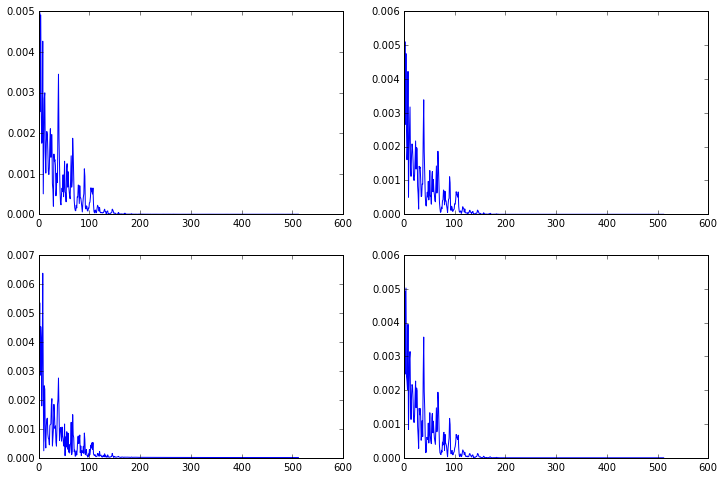

In [23]:
frame = audio[1*44100 : 1*44100 + 1024]

plt.figure(figsize=(12, 8))
#plt.rcParams['figure.figsize'] = (12.0, 8.0)
#plt.subplots_adjust(wspace=0, hspace=0)

w_hm = Windowing(type = 'hamming')
spec = spectrum(w_hm(frame))
plt.subplot(2,2,1); plt.plot(spec)

w_tr = Windowing(type = 'triangular')
spec = spectrum(w_tr(frame))
plt.subplot(2,2,2); plt.plot(spec)

w_sq = Windowing(type = 'square')
spec = spectrum(w_sq(frame))
plt.subplot(2,2,3); plt.plot(spec)

w_hn = Windowing(type = 'hann')
spec = spectrum(w_hn(frame))
plt.subplot(2,2,4); plt.plot(spec)

### Mel-frequency cepstrum coefficients

Showing fingerprint (every 512 ms?) by window type.

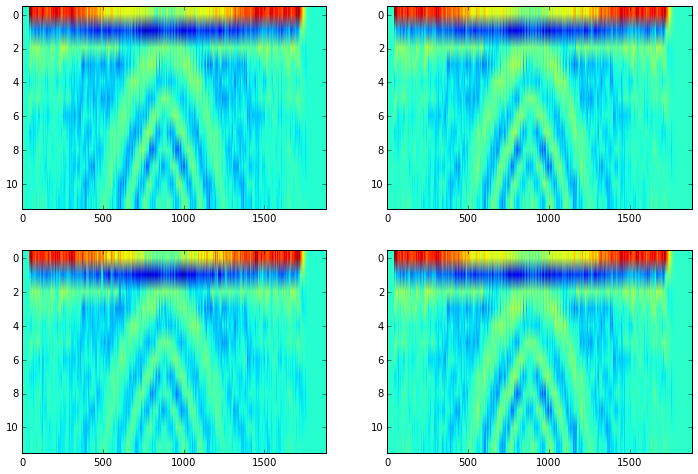

In [24]:
plt.figure(figsize=(12, 8))

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_hm(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,1); plt.imshow(mfccs[1:,:], aspect = 'auto')

#****

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_tr(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)  
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,2); plt.imshow(mfccs[1:,:], aspect = 'auto')

#****

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_sq(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,3); plt.imshow(mfccs[1:,:], aspect = 'auto')

#****

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_hn(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)
        
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,4); plt.imshow(mfccs[1:,:], aspect = 'auto')


# Ignored the first MFCC coefficient to disregard the power of the signal and only plot its spectral shape
#plt.imshow(mfccs[1:,:], aspect = 'auto')


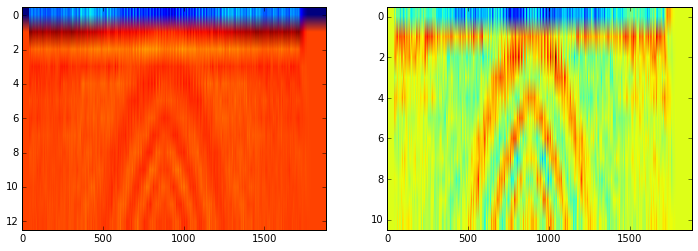

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1); plt.imshow(mfccs[:,:], aspect = 'auto')

plt.subplot(1,2,2); plt.imshow(mfccs[2:,:], aspect = 'auto')

### FFT

Not working.

In [26]:
# FFT() would return the complex FFT, here we just want the magnitude spectrum

fft = FFT()

# Computes the positive complex STFT (Short-term Fourier transform) of an array of Reals using the FFT algorithm. 
# The resulting fft has a size of (s/2)+1, where s is the size of the input frame. 
# At the moment FFT can only be computed on frames which size is even and non zero, otherwise exception.


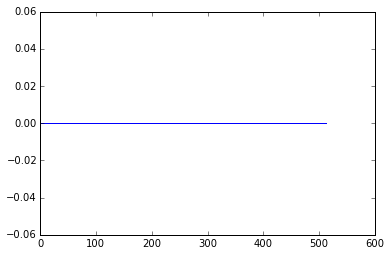

In [33]:
fftb = fft(w_hn(frame))

plt.plot(fftb)


### Pooling

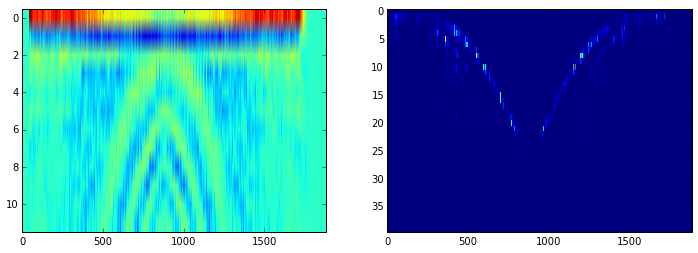

In [38]:
pool = essentia.Pool()

# A Pool is a container similar a Python dict which can contain any type of values... like a directory. 
# So, if you're going to apply diff functions to a single file, store their output centrally in the pool.
# Values are stored using a name which represent the path to these values where dot (‘.’) chars are separators. 
# Other pool advantage: data you get out of it is already in an essentia.array format, so you can transpose (.T) it

for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_hn(frame)))
    pool.add('lowlevel.mfcc', mfcc_coeffs)
    pool.add('lowlevel.mfcc_bands', mfcc_bands)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1); plt.imshow(pool['lowlevel.mfcc'].T[1:,:], aspect = 'auto')
plt.subplot(1,2,2); plt.imshow(pool['lowlevel.mfcc_bands'].T, aspect = 'auto', interpolation = 'nearest')

### Save pool

In [41]:
# Writing results to file using the YamlOutput algorithm, which writes a pool in a file using the YAML or JSON format.
output = YamlOutput(filename = 'mfcc.sig') # use "format = 'json'" for JSON output
output(pool)

# or as a one-liner:
#YamlOutput(filename = 'mfcc.sig')(pool)

In [42]:
# Assume we only want mean and variance of the frames. Use PoolAggregator on pool to get a new pool with aggregations.
aggrPool = PoolAggregator(defaultStats = [ 'mean', 'var' ])(pool)

print 'Original pool descriptor names:'
print pool.descriptorNames()
print
print 'Aggregated pool descriptor names:'
print aggrPool.descriptorNames()

# and ouput those results in a file
YamlOutput(filename = 'mfccaggr.sig')(aggrPool)

Original pool descriptor names:
['lowlevel.mfcc', 'lowlevel.mfcc_bands']

Aggregated pool descriptor names:
['lowlevel.mfcc.mean', 'lowlevel.mfcc.var', 'lowlevel.mfcc_bands.mean', 'lowlevel.mfcc_bands.var']


## Stream processing

In [43]:
import essentia
from essentia.streaming import *

In [44]:
# and instantiate our algorithms

loader = MonoLoader(filename = 'data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav')
frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
w = Windowing(type = 'hann')
spec = Spectrum()
mfcc = MFCC()


In [45]:
# In streaming, instead of calling algorithms like functions, we need to
# connect their inputs and outputs. This is done using the >> operator
#
# The graph we want to connect looks like this:
#  ____________       _________________       ________________       __________________
# /            \     /                 \     /                \     /                  \
# | MonoLoader |     |   FrameCutter   |     |   Windowing    |     |     Spectrum     |
# |            |     |                 |     |                |     |                  |
# |     audio -+-->--+- signal  frame -+-->--+- frame  frame -+-->--+- frame spectrum -+-->-\
# \____________/     \_________________/     \________________/     \__________________/    |
#                                                                                           |
#  /----------------------------------------------------------------------------------------/
#  |    ___________________
#  |   /                   \
#  |   |      MFCC         |
#  |   |            bands -+-->-- ???
#  \->-+- spectrum         |
#      |             mfcc -+-->-- ???
#      \___________________/
#

loader.audio >> frameCutter.signal
frameCutter.frame >> w.frame >> spec.frame
spec.spectrum >> mfcc.spectrum


<essentia.streaming._StreamConnector instance at 0x129d2e170>

In [46]:
# When building a network, all inputs need to be connected, no matter what, otherwise the network
# cannot be started

essentia.run(loader)


RuntimeError: MFCC::bands is not connected to any sink...

In [47]:
#  ____________       _________________       ________________       __________________
# /            \     /                 \     /                \     /                  \
# | MonoLoader |     |   FrameCutter   |     |   Windowing    |     |     Spectrum     |
# |            |     |                 |     |                |     |                  |
# |     audio -+-->--+- signal  frame -+-->--+- frame  frame -+-->--+- frame spectrum -+-->-\
# \____________/     \_________________/     \________________/     \__________________/    |
#                                                                                           |
#  /----------------------------------------------------------------------------------------/
#  |    ___________________              _________
#  |   /                   \            /         \
#  |   |      MFCC         |      /-->--+ NOWHERE |
#  |   |            bands -+-->--/      \_________/
#  \->-+- spectrum         |
#      |             mfcc -+-->--\       _____________________
#      \___________________/      \     /                     \
#                                  -->--+ Pool: lowlevel.mfcc |
#                                       \_____________________/

pool = essentia.Pool()

mfcc.bands >> None
mfcc.mfcc >> (pool, 'lowlevel.mfcc')

essentia.run(loader)

print 'Pool contains %d frames of MFCCs' % len(pool['lowlevel.mfcc'])


Pool contains 1884 frames of MFCCs


In [48]:
# Let's try writing directly to a text file, no pool and no yaml files

# we first need to disconnect the old connection to the pool to avoid putting the same data in there again
mfcc.mfcc.disconnect((pool, 'lowlevel.mfcc'))

# we create a FileOutput
fileout = FileOutput(filename = 'mfccframes.txt')

# and connect it: it is a special connection as it has no input, because it can actually
# take any type of input (the other algorithms will complain if you try to connect an output
# to an input of a different type)
mfcc.mfcc >> fileout

# reset the network otherwise the loader in particular will not do anything useful
essentia.reset(loader)

# and rerun it!
essentia.run(loader)


# Madmom tutorial
## Audio Signal Handling

In [2]:
import madmom as mad

In [3]:
# process as function
signal, sample_rate = mad.audio.signal.load_wave_file('data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav')
signal, sample_rate

(memmap([[0, 0],
        [0, 0],
        [0, 0],
        ..., 
        [0, 0],
        [0, 0],
        [0, 0]], dtype=int16), 44100)

In [30]:
# process as class where instance of class holds values in variable, here .signal and .sample_rate
#sig = mad.audio.signal.Signal('data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav')

sig = mad.audio.signal.Signal('data/sample.wav')
sig, sig.sample_rate

(Signal([-2494, -2510, -2484, ...,   520,   655,   639], dtype=int16), 44100)

In [31]:
# To split the signal into frames of 2048 samples length which overlap by 441 samples, 
# we use the existing Signal object as the first argument for instantiation of the FramedSignal object.

fs = mad.audio.signal.FramedSignal(sig, frame_size=2048, hop_size=441)
# note: downstream classes smart enough to know which of the class vars to use.

fs
# the FramedSignal is implemented as an indexable/iterable class, so we can access the individual frames like
# a numpy array, e.g. slice the signal. The only difference is that the index -1 does not refer to the last frame,
# but to the frame left of the first one. Note: the reason why the FramedSignal is implemented this way and not as
# a strided view on the signal numpy array is that we also want to be able to use float hop sizes, e.g. to get a 
# constant frame rate. E.g. to get a frame rate of 200, we could either set the hop_size to 220.5 samples or simply pass the fps argument instead.

In [33]:
# The fps argument is converted into the appropriate hop_size and vice versa. This conversion could be performed 
# automatically since the Signal object (mad.audio.signal) has also the needed sample rate. 

# Thus constant frame rates could be achieved independently of the sample rate of the signal. 
# No need to resample all audio files to the same sample rate beforehand.

fs.frame_rate, fs.hop_size, fs[0]

#fs.shape

(100.0,
 441.0,
 Signal([    0,     0,     0, ..., -4553, -4666, -4589], dtype=int16))

In [34]:
fs_200 = mad.audio.signal.FramedSignal(sig, frame_size=2048, fps=200)
fs_200
fs_200.frame_rate, fs_200.hop_size, fs_200[0]

(200.0,
 220.5,
 Signal([    0,     0,     0, ..., -4553, -4666, -4589], dtype=int16))

In [35]:
# Based on this FramedSignal we can now continue to calculate the STFT of it. 
# The STFT class is (of course) a subclass of a numpy array, i.e. it has a dtype, can be sliced, transposed etc..

stft = mad.audio.stft.STFT(fs[0])
stft[0:2]

ShortTimeFourierTransform([[ 0.00000000+0.j        ,  0.00000000+0.j        ,
         0.00000000-0.j        , ...,  0.00000000+0.j        ,
         0.00000000+0.j        ,  0.00000000+0.j        ],
       [-0.00602395+0.j        , -0.31079096+0.2225071j ,
        -0.75507450-0.23502596j, ..., -0.00865676+0.01141211j,
        -0.01300879-0.00601273j,  0.00308136-0.01400267j]], dtype=complex64)

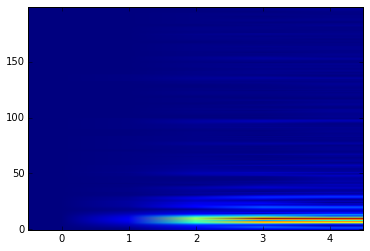

In [41]:
# STFT magnitudes are often used for MIR. Magnitude spectrograms are represented by the Spectrogram class.

spec = mad.audio.spectrogram.Spectrogram(stft)

plt.imshow(spec[:, :200].T, aspect='auto', origin='lower')

In [59]:
# While Spectrogram class expects a STFT instance as its only argument, we could also have passed any other
# data to it as long as a STFT object can be instantiated from it. This can be a FramedSignal or Signal instance
# or just a file name (or file handle). Additional keywords are passed accordingly, i.e.:

spec = mad.audio.spectrogram.Spectrogram('data/sample.wav', frame_size=2048, hop_size=200, fft_size=4096)

spec.shape, spec.bin_frequencies

((618, 2048), array([  0.00000000e+00,   1.07666016e+01,   2.15332031e+01, ...,
          2.20177002e+04,   2.20284668e+04,   2.20392334e+04]))

## Onset detection

In [43]:
from scipy.ndimage.filters import maximum_filter

In [45]:
# Example, the SuperFlux onset detection algorithm is based on the spectral flux algorithm. The spectral flux is
# defined as the sum (or mean) of the first order differences of the magnitude spectrogram of an audio file:

spec = mad.audio.spectrogram.Spectrogram('data/sample.wav')

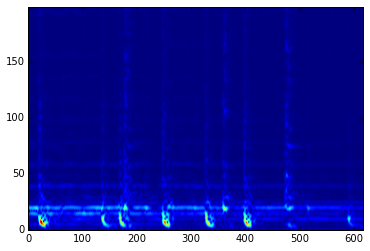

In [63]:
plt.figure()
plt.imshow(spec[:, :200].T, origin='lower', aspect='auto')

In [64]:
# manual calculation:

    # calculate the difference
diff = np.diff(spec, axis=0)

    # keep only the positive differences
pos_diff = np.maximum(0, diff)

    # sum everything to get the spectral flux
sf = np.sum(pos_diff, axis=1)

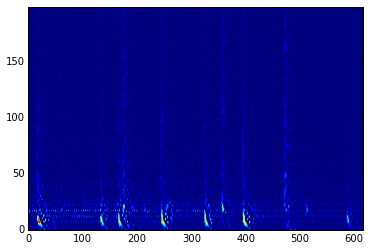

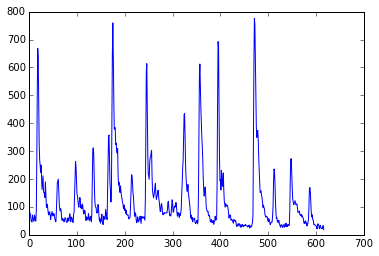

In [65]:
plt.figure()
plt.imshow(pos_diff[:, :200].T, origin='lower', aspect='auto')
plt.figure()
plt.plot(sf)

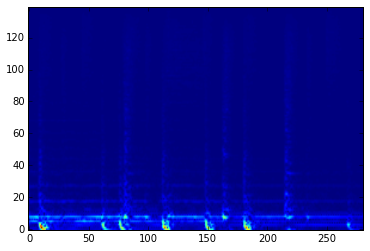

In [51]:
# same thing using madmom

sf = mad.features.onsets.spectral_flux(spec)

# Spectral flux can do onset detection. So can SuperFlux. Superflux creates a linearly spaced magnitude spectrogram
# that is filtered logarithmically (with 24 bands per octave). madmom convenience class FilteredSpectrogram does this.
# It takes Filterbank instance or class as input. We pass the number of bands as an additional argument. The parameter
# which sets the number of bands 'num_bands' is always named 'num_bands', independent of whether it represents the 
# total number of bands (as for a MelFilterbank) or bands per octave (as for the LogFilterbank).

filt_spec = mad.audio.spectrogram.FilteredSpectrogram(spec, filterbank=mad.audio.filters.LogFilterbank,
                                                      num_bands=24)

plt.imshow(filt_spec.T, origin='lower', aspect='auto')

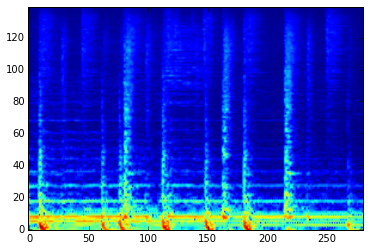

In [52]:
# To better match the perception of loudness of humans, the filtered spectrogram is also scaled logarithmically
# (after adding a constant value of 1 to avoid negative values).

log_spec = mad.audio.spectrogram.LogarithmicSpectrogram(filt_spec, add=1)

plt.imshow(log_spec.T, origin='lower', aspect='auto')

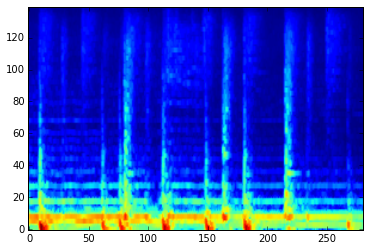

In [53]:
# Contrary to the spectral flux which uses the temporal evolution of the magnitudes (i.e. calculate difference), 
# the difference is not calculated relative to the same spectrogram, but rather a maximum filtered version thereof.
# The effect of this step is that peaks are "widened" in frequency direction.

# maximum filter size spreads over 3 frequency bins
size = (1, 3)
max_spec = maximum_filter(log_spec, size=size)

plt.imshow(max_spec.T, origin='lower', aspect='auto')

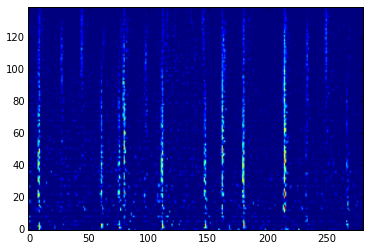

In [54]:
# Now we continue to calculate the difference w.r.t. this "widened" spectrogram.

# init the diff array
diff = np.zeros_like(log_spec)

# calculate the difference between the log. spec and the max. filtered version thereof
diff[1:] = (log_spec[1:] - max_spec[: -1])

# then continue as with the spectral flux, i.e. keep only the positive differences
pos_diff = np.maximum(0, diff)

plt.figure()
plt.imshow(pos_diff.T, origin='lower', aspect='auto')

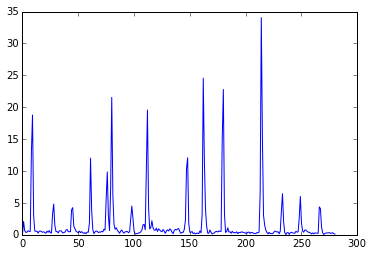

In [55]:
# sum everything to get the onset detection function
superflux = np.sum(pos_diff, axis=1)

plt.figure()
plt.plot(superflux)

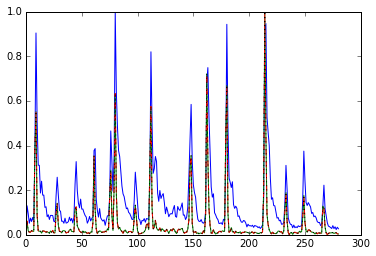

In [58]:
# To achieve the same with madmom, some classes have some of the needed functionality already built in for 
# convienience e.g. the LogarithmicFilteredSpectrogram does all the filtering and scaling combined in a single 
# class (accepting a STFT, FramedSignal, Signal object or a file name as input). Appropriate arguments can be 
# given and the ones not understood by the class are passed if there's the need to instantiate an object up the 
# hierarchy.

log_filt_spec = mad.audio.spectrogram.LogarithmicFilteredSpectrogram('data/sample.wav', num_bands=24)

# The SpectrogramDifference class calculates the first order difference of a spectrogram. It accepts a couple 
# of parameters, such as diff_frames to set the number of frames how far apart the difference should be calculated,
# and adds functionality to perform maximum filtering (via diff_max_bins) or returning only positive differences 
# (via positive_diffs). For convienience, the resulting difference spectrogram has the same shape as the given one
# (np.diff() does not), with all frames < diff_frames set to zero.

# this is the same as before:
superflux_diff = mad.audio.spectrogram.SpectrogramDifference(log_filt_spec, positive_diffs=True, diff_max_bins=3)

superflux_2 = np.sum(superflux_diff, axis=1)

# Of course, the same functionality can be found as madmom.features.onsets.superflux(). The function implements 
# the maximum filtering, but the user has to pass an spectrogram obtained with appropriate parameters to make 
# the function work as desired.

superflux_3 = mad.features.onsets.superflux(log_filt_spec)

# we scale them to have the same range
plt.figure()
plt.plot(sf / sf.max(), 'b')  # blue
plt.plot(superflux / superflux.max(), 'g')  # green
plt.plot(superflux_2 / superflux_2.max(), 'r--')  # dashed red
plt.plot(superflux_3 / superflux_3.max(), 'k:')  # dotted black

# The SuperFlux function has sharper peaks and a lower overall noise floor as compared to the normal spectral 
# flux, which makes it easier to detect the peaks.

# V1: Import piano train / test data

1. Take their lists of train and test data
2. Create list object
3. Feed it to a process to either iteratively or bulk load files from directory
4. Perform log scale transform of input wav
5. Come back to other features, chords


# Learn to map sound to notes

1. Take professional music sound files
2. Play, logging spectrum (frequency / time) and other attributes
    a. https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction, OR
    b. 
3. Predict notes based on sound
    a. input spectrum is the "X"
    b. sheet music notes are the "y" (notes A, B, C, etc.)

# V1: Generate harp note / chord train / test files

Garageband or other to generate:
1. individual instrument note (pitch?), chord by major/minor, octave, inversion
2. sequence files w/ varying amounts of spacing
3. mp3's of classical music for which you can easily veryify the notes


# V2: Standard: Fingerprint music files

In [ ]:
# use FFT, MFCC, etc to create a fignerprint of each of the music files s/t when user starts playing, you can take notes they've played and match 

# V2: Streaming: Extract note Sample

# V2: Streaming: Search / match sample to fingerprints

# Establish stream

Use pyaudio to instantiate stream for practice session

In [ ]:
WIDTH = 2
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()

def callback(in_data, frame_count, time_info, status):
    return (in_data, pyaudio.paContinue)

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                stream_callback=callback)

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)

stream.stop_stream()
stream.close()

p.terminate()

# Display mode

1. Accept song selection
2. Load / display sheet music
3. Listen for start
4. Recieve sounds / translate notes
5. Track progress w/ vertical bar
6. Spot repeats re-setting tracking bar

In [ ]:
# https://github.com/tyiannak/pyAudioAnalysis
# http://essentia.upf.edu/documentation/


# Evaluate mode

1. display mode functionality including tracking progress
2. record playing. overlay repeats. you're tracking stats. so, obj s/b:
    a. to get through song re-playing pieces as required, THEN
    b. to get through song cleanly
3. comparing played to professional
    a. option to play:
        i. metrinome 
        ii. professional a low volume
4. identify discrpancies (timing after prior note, incorrect note)
    a. Gaia, a C++ library with python bindings which implement similarity measures and classification on the results of audio analysis, and generate classification models that Essentia can use to compute high-level description of music.
5. show discrepancies
    a. accept tolerances (+/- time, other?)
    b. show played note in red (i.e., before/after, above/below).
6. show / log statistics
    a. accuracy
    b. similarity
    c. error types and frequency distribution
        i. early,
        ii. late
        iii. wrong note
    d. problem areas

# Interactive mode

1. evaluate mode functionality
2. prompt session info and imprint voice of user for command interface
    a. "this is []. the date is []. i'll be practicing for about [] minutes."
3. voice commands
    a. "replay [] notes" - defaults to: 5 notes, played version
    b. "replay base [] notes"
    c. "loop [] notes" - 
        ii. Loop [] notes / Stop Loop
2. 

# References

This project would not be possible without the invaluable assistance of:

## Training data

The MAPS piano data set. Roughly 40G of piano notes, chords, music assembled by V. Emiya for her PhD thesis at Telecom ParisTech/ENST in 2008 and in conjunction with R. Badeau, B. David for their paper "Multipitch estimation of piano sounds using a new probabilistic spectral smoothness principle"<cite data-cite="emiya2010multipitch"></cite>


In [ ]:
# for installing latex, bibtex and pdf-ing jupyter notenooks: https://www.youtube.com/watch?v=m3o1KXA1Rjk